In [1]:
import pandas as pd

In [46]:
files = ! ls ./DR_events 
dfs = []

In [47]:
for file in files:
    if file[-4:] == '.csv':
        dfs.append((file[:-4], pd.read_csv('./DR_events/' + file)))

In [48]:
rmses = [(i[0], i[1]['test rmse (kw)'][0]) for i in dfs]

In [49]:
pd.DataFrame(rmses).to_csv('rmse.csv')

In [118]:
sites = ! ls ./test

In [124]:
import os 

In [125]:
os.listdir('./test/avenal-animal-shelter')

['2018-07-20.csv',
 '2016-07-15.csv',
 '2017-07-28.csv',
 '2017-07-10.csv',
 '2016-06-29.csv',
 '2016-07-27.csv',
 '2016-07-26.csv']

In [2]:
dfs = []

In [136]:
for site in sites:
    files = os.listdir('./test/'+site)
    for file in files:
        try:
            dfs.append((file[:-4], pd.read_csv('./test/'+site+'/' + file)))
        except Exception as e:
            print(e)
            print(site)
            print(file)

Error tokenizing data. C error: Calling read(nbytes) on source failed. Try engine='python'.
modified
north-berkeley-senior-center
Error tokenizing data. C error: Calling read(nbytes) on source failed. Try engine='python'.
modified
avenal-movie-theatre
Error tokenizing data. C error: Calling read(nbytes) on source failed. Try engine='python'.
modified
avenal-veterans-hall
Error tokenizing data. C error: Calling read(nbytes) on source failed. Try engine='python'.
modified
berkeley-corporate-yard


In [138]:
len(dfs)

385

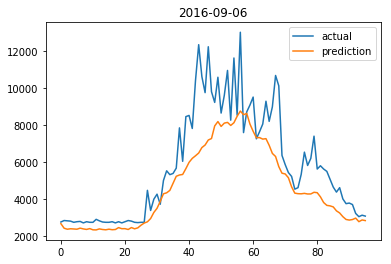

In [72]:
import matplotlib.pyplot as plt
i = 3
df = dfs[i][1]
plt.plot(range(len(df)), df['actual_power'], label = 'actual')
plt.plot(range(len(df)), df['prediction'], label = 'prediction')
plt.title(dfs[i][0])
plt.legend()

In [160]:
all_tests = pd.concat([df[1] for df in dfs])

/Users/jleyden/anaconda3/envs/mortar/lib/python3.6/site-packages/ipykernel/__main__.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  if __name__ == '__main__':


In [161]:
all_tests.index = pd.DatetimeIndex(all_tests['Unnamed: 0'], tz='UTC')

In [162]:
all_tests.index

DatetimeIndex(['2016-07-14 08:00:00+00:00', '2016-07-14 08:15:00+00:00',
               '2016-07-14 08:30:00+00:00', '2016-07-14 08:45:00+00:00',
               '2016-07-14 09:00:00+00:00', '2016-07-14 09:15:00+00:00',
               '2016-07-14 09:30:00+00:00', '2016-07-14 09:45:00+00:00',
               '2016-07-14 10:00:00+00:00', '2016-07-14 10:15:00+00:00',
               ...
               '2016-07-27 05:30:00+00:00', '2016-07-27 05:45:00+00:00',
               '2016-07-27 06:00:00+00:00', '2016-07-27 06:15:00+00:00',
               '2016-07-27 06:30:00+00:00', '2016-07-27 06:45:00+00:00',
               '2016-07-27 07:00:00+00:00', '2016-07-27 07:15:00+00:00',
               '2016-07-27 07:30:00+00:00', '2016-07-27 07:45:00+00:00'],
              dtype='datetime64[ns, UTC]', name='Unnamed: 0', length=36384, freq=None)

In [163]:
import pytz
local = all_tests.index.tz_convert('US/Pacific')

In [164]:
all_tests.index = local

In [165]:
all_tests = all_tests.drop(columns=['Unnamed: 0'])

In [166]:
all_tests['hour'] = all_tests.index.hour

In [167]:
all_tests = all_tests.dropna()
all_tests = all_tests[all_tests.actual_power != '[nan]']

In [168]:
all_tests['actual_power'] = all_tests['actual_power'].astype(float)

In [169]:
all_tests['error'] = all_tests['prediction'] - all_tests['actual_power']

In [170]:
errors_by_hour = all_tests.groupby('hour').mean()['error']

<BarContainer object of 24 artists>

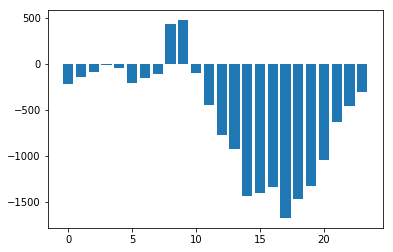

In [171]:
plt.bar(errors_by_hour.index, errors_by_hour)

In [172]:
all_tests['month'] = all_tests.index.month

In [173]:
errors_by_month = all_tests.groupby('month').mean()['error']

<BarContainer object of 9 artists>

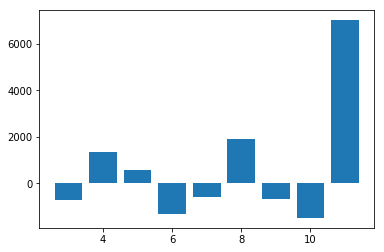

In [174]:
plt.bar(errors_by_month.index, errors_by_month)

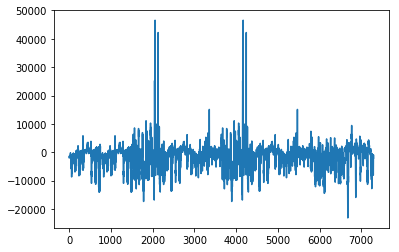

In [175]:
vals = all_tests[all_tests['month'] == 10]['error']
plt.plot(range(len(vals)), vals)

In [176]:
from sklearn.metrics import mean_squared_error
import numpy as np

In [177]:
np.sqrt(mean_squared_error(all_tests['actual_power'], all_tests['prediction']))

4857.108394107363

In [178]:
no_zero = all_tests[all_tests['actual_power'] != 0]

<BarContainer object of 9 artists>

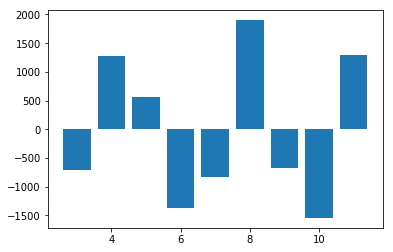

In [179]:
errors_by_month = no_zero.groupby('month').mean()['error']
plt.bar(errors_by_month.index, errors_by_month)

In [180]:
len(no_zero)/ len(all_tests)

0.9744755244755244

In [181]:
np.sqrt(mean_squared_error(no_zero['actual_power'], no_zero['prediction']))

4680.548640846861

/Users/jleyden/anaconda3/envs/mortar/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


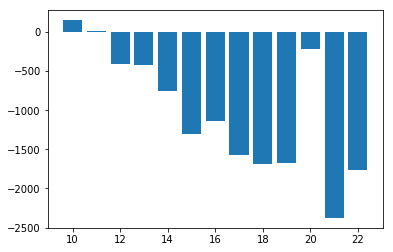

In [182]:
interval_five = np.round(no_zero['actual_weather'] / 5)
no_zero['interval_five'] = interval_five
errors = no_zero.groupby('interval_five').mean()['error']
plt.bar(errors.index, errors);

-1100.5589345417025


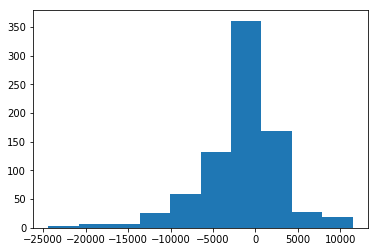

In [194]:
interval = 95
interval_errors = no_zero[no_zero['interval_five'] == interval/5]['error']
plt.hist(interval_errors)
print(np.median(interval_errors))

In [198]:
interval_median_errors = no_zero.groupby('interval_five').median()['error']

Text(0, 0.5, 'median residual (wh)')

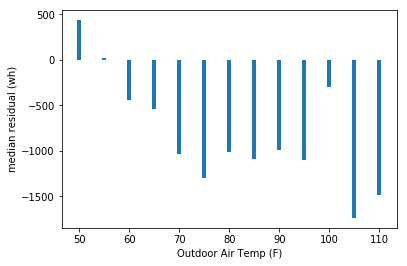

In [205]:
plt.bar(interval_median_errors.index*5, interval_median_errors)
plt.xlabel('Outdoor Air Temp (F)')
plt.ylabel('median residual (wh)')